# Project Milestone Report
### Magdalena Barros, Paula Cadena, Michael Rosenbaum | CAPP 30254: Machine Learning for Public Policy 

This report describes our current progress to complete the CAPP 30254 proxy means test project. In our first two weeks, we've conducted a series of data exploration exercises to better define our training data as well as determined what our approach will be to implement and compare a set of models.

Our approach will be to use a set of .py functions to analyze the data and create 3 candidate datasets to each contribute to the cleaning process. Then, we will create a data pipeline to train and evaluate the efficacy of 4 models we have covered in class:
- Regression forests of some variety (XGBoost, standard CART)
- K-Nearest Neighbors
- Penalized multinomial logistic regressions of some variety (Elastic net, LASSO, etc.)
- A simple Neural Net

We will evaluate these models based on the model evaluation criteria we will learn in the remaining weeks of the course, likely focusing on predictive accuracy, not computation time due to the relatively smaller size of the data.

## 1 | Data Exploration

Our data exploration has focued on understanding the underlying dataset. The data comes from a [2017 ILO survey administered](https://webapps.ilo.org/surveyLib/index.php/catalog/7230/related-materials) by the Intra-American Development Bank.

It is drawn from a nationally representative household survey and includes a subset of household- and individual-level variables that are cleaned by the IDB.

So far, our main focus has been data quality assurance and data management. We have:
- Loaded the data into Python;
- Removed extraneous variables created by the IDB such as squared age that are fully dependent on underlying data from respondents. 
- Reviewed the survey documentation to understand the data generation process.
- Evaluated data quality on missingness, item nonresponse, and 
- Created a development and training data split so that our internal analysis of missing

### Results

Three variables have missing values:


In [4]:
# External packages
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Internal functions
sys.path.append(os.path.dirname(os.path.abspath(''))) # From https://stackoverflow.com/questions/9856683/using-pythons-os-path-how-do-i-go-up-one-directory
from model.clean import load_data

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
cr_df = load_data("train.csv")
cr_df.isnull().sum()[cr_df.isnull().sum() != 0]

v2a1        6860
v18q1       7342
rez_esc     7928
meaneduc       5
dtype: int64

explain decision for missing values:


### Outcome Distribution

TODO: Outcome skewed (look at smote or ADAsyn)

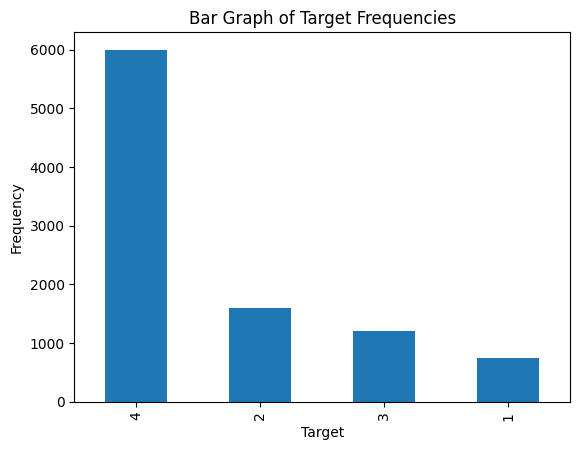

In [6]:
target_counts = cr_df['Target'].value_counts()

target_counts.plot(kind='bar')

plt.xlabel('Target')
plt.ylabel('Frequency')
plt.title('Bar Graph of Target Frequencies')
plt.show()

In [7]:
# Calculate value counts for the 'Target' column subset by idhogar:
subset_idhogar = cr_df.drop_duplicates(subset=['idhogar'])['Target']
value_counts = subset_idhogar.value_counts()

# Calculate total number of observations
total_obs = len(subset_idhogar)

# Calculate percentages for each value and round to two decimal places
percentages = (value_counts / total_obs * 100).round(2)

# Add the percentage symbol '%' to each value
percentages_with_symbol = percentages.astype(str) + '%'

print("Percentage of each value in the 'Target' column subset on the 'idhogar':")
print(percentages_with_symbol)

Percentage of each value in the 'Target' column subset on the 'idhogar':
Target
4    65.39%
2    15.19%
3    12.22%
1      7.2%
Name: count, dtype: object


In [8]:
X = cr_df.drop(columns=['Target'])  
y = cr_df['Target']

# Split data into training (70%) and temporary (30%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to the training set
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Split the temporary set into validation (10%) and test (20%) sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

print("Training set size after SMOTE:", len(X_train_resampled))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

ValueError: could not convert string to float: 'ID_0318f001f'

### Decisions

- Retain `hhsize` and drop `tamhog`, `r413`, `tamviv` as `hhsize` is calculated by the survey software based on the household roster, whereas each other is not aligned with the counts of household compositions variables (age, sex, etc.) 

### Details

This has lead us to a foundational dataset with only data from the underlying population (and not IDB analysts) remaining, only single indicator variables for discrete variables (i.e., only keeping male from male and female), as well as summary statistics to describe missingness and item response rates for single selection items that are encoded as a series of indicator variables.

We will create three sets of training data to apply our models on. These training sets aim to compare different approaches to defining the taregt population:

1. **Parsimonious household-level dataset**: The smallest and simplest dataset we can create of household-level data. This assumes that the survey data contains a lot of noisy variables and attempts to select candidate variables most strongly associated with underlying proxies for poverty status: liquid and illiquid wealth, income, income potential, and resilience.
1. **Complicated household-level dataset**: Keeping the data at the household-level, we will generate features from the individual-level data and a set of more complex interactions between candidate features.
1. **Respondent-level dataset**: We will make individual predictions of poverty status based on individuals in each household and then train weights for the predictions for a composite. This will take advantage of variance in responses among household members in the survey to take advantage of predictors of non-classical measurement error associated with respondent differences.

## 2 | Feature Engineering

We have started to develop features with a focus on three initial types of features:

- Comparisons between individual-level responses and household-responses (e.g., minimum education or number of students behind grade-level)
- Collapsing categories for categoricl variables with low response rates.
- Interactions between plausibly-related variables (e.g., water AND electricity)

## 3 | Future work

We have developed developed to-do list for future work to ensure that we are on track for completing the fina work.

- \[May 3\] Create candidate datasets
- \[May 10\] Model selection
- \[May 17\] Model validation
- \[May 19\] Report completion